# Part 1: Getting started

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PATH'] = '/home/ryan/Downloads/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']

## Fetch the jet tagging dataset from Open ML

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [3]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [4]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [5]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [6]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [20]:
# kaggle dataset
model = Sequential()
model.add(Dense(96, input_shape=(96,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))

model.add(Dense(48, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))

model.add(Dense(6, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

In [8]:
# model = Sequential()
# model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
# model.add(Activation(activation='relu', name='relu1'))

# model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
# model.add(Activation(activation='relu', name='relu2'))

# model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
# model.add(Activation(activation='relu', name='relu3'))

# model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
# model.add(Activation(activation='softmax', name='softmax'))

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [9]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_1')
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/30
  1/487 [..............................] - ETA: 0s - loss: 1.6388 - accuracy: 0.3027WARNING:tensorflow:From /home/ryan/anaconda3/envs/hls4ml-tutorial-0.4.0/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
487/487 [==============================] - ETA: 0s - loss: 1.3290 - accuracy: 0.5161
***callbacks***
saving losses to model_1/losses.log

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_1/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 1.3290 - accuracy:


Epoch 00024: val_loss improved from 0.77148 to 0.76954, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00024: saving model to model_1/KERAS_check_model_last.h5

Epoch 00024: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.7653 - accuracy: 0.7500 - val_loss: 0.7695 - val_accuracy: 0.7493
Epoch 25/30
476/487 [============================>.] - ETA: 0s - loss: 0.7635 - accuracy: 0.7505
***callbacks***
saving losses to model_1/losses.log

Epoch 00025: val_loss improved from 0.76954 to 0.76789, saving model to model_1/KERAS_check_best_model.h5

Epoch 00025: val_loss improved from 0.76954 to 0.76789, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00025: saving model to model_1/KERAS_check_model_last.h5

Epoch 00025: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.76

## Check performance
Check the accuracy and make a ROC curve

Accuracy: 0.7502650602409638


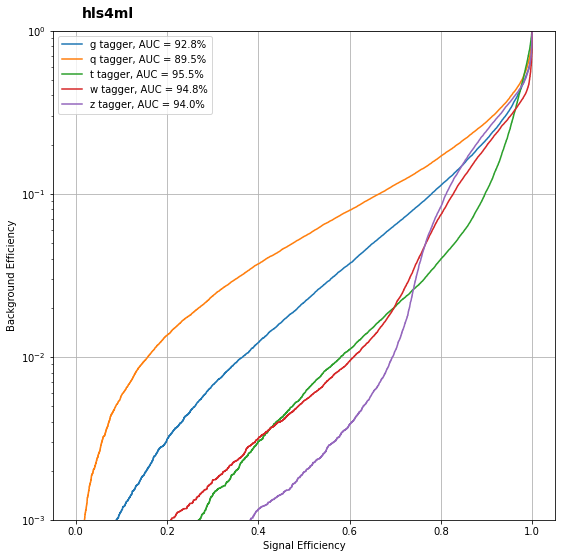

In [10]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)

# Convert the model to FPGA firmware with hls4ml
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
Then we will synthesize the model with Vivado HLS and check the metrics of latency and FPGA resource usage.

## Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [21]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_2/hls4ml_prj',
                                                       fpga_part='xczu3eg-sbva484-2-e')

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
-----------------------------------
Configuration
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
-----------------------------------
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, current shape: [[None, 96]]
Layer name: fc1, layer type: Dense, current shape: [[None, 96]]
Layer name: relu1, layer type: Activation, current shape: [[None, 96]]
Layer name: fc2, layer type: Dense, current shape: [[None, 96]]
Layer name: relu2, layer type: Activation, current shape: [[None, 48]]
L

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

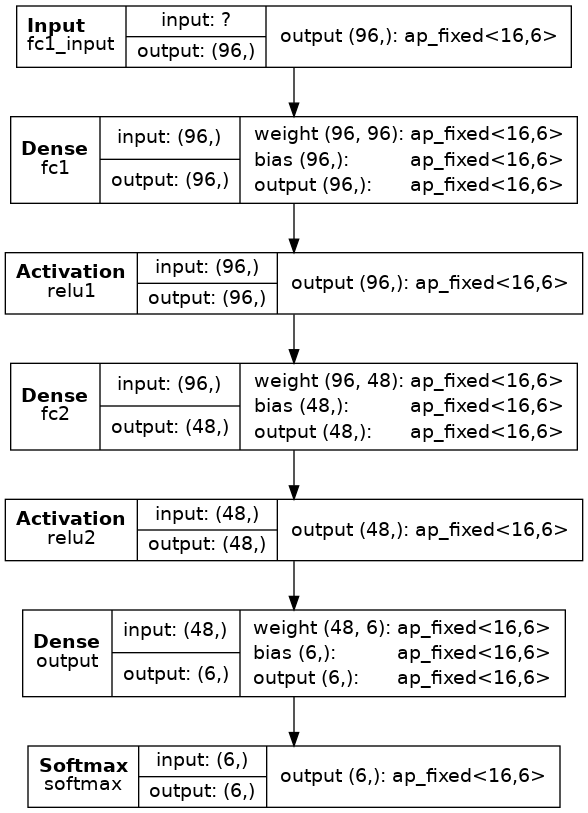

In [22]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [23]:
hls_model.compile()
# y_hls = hls_model.predict(X_test)
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

Writing HLS project
Done


Exception: Input size mismatch, got (), expected [96]

## Compare
That was easy! Now let's see how the performance compares to Keras:

Keras  Accuracy: 0.7502650602409638
hls4ml Accuracy: 0.7503132530120482


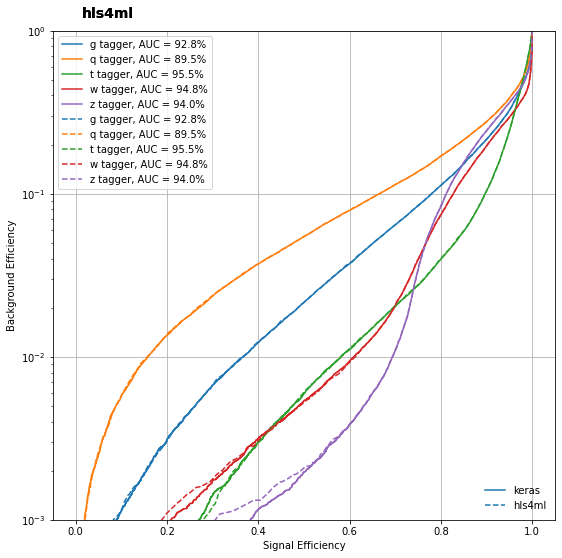

In [14]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now we'll actually use Vivado HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vivado HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vivado_hls.log`

In [ ]:
hls_model.build()

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [18]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

Found 1 solution(s) in model_1/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0253906 0.0917969 0.161133 0.638672 0.103516 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Fri Feb 26 04:37:25 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +-

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)